# IAU Projekt 2. fáza

### Autori: Martin Raffáč (50%), Tibor Vanek (50%)

dataset číslo **003**

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mat
import matplotlib.pylab as pylab
import statsmodels.api as sm
import statsmodels.stats as sm_stats
import statsmodels.stats.api as sms
import scipy.stats as stats
from matplotlib import pyplot
from collections import Counter

In [140]:
filename1 = "./dataset-003/measurements.csv"
measurements = pd.read_csv(filename1, sep='\t')

In [141]:
filename2 = "./dataset-003/stations.csv"
stations = pd.read_csv(filename2, sep='\t')

In [142]:
# Vyhľadanie duplicitných záznamov

duplicate = measurements[measurements.duplicated()]
merged = measurements.drop_duplicates()
print("Počet záznamov v datasete: "+str(len(measurements)))
print("V datasete sa nachádza: " + str(len(duplicate)) + " duplikátov.")

Počet záznamov v datasete: 12075
V datasete sa nachádza: 178 duplikátov.


Pomocou týchto príkazov sme zistili či sa v datasete nachádzajú duplicitné záznamy, program detegoval 178 duplikátnych záznamov.
Tieto duplikáty sme z datasetu vymazali aby nespôsobovali chyby pri neskoršej práci s dátami.


In [143]:
measurements.isnull().sum()

longitude     0
C2H3NO5      48
O3           48
CO           48
warning      48
Pb           48
PAHs         49
PM2.5        48
PRES          0
TEMP         48
latitude      0
NH3          48
H2CO         48
SO2          48
CH4          49
PM10         49
CFCs         50
NOx          49
dtype: int64

Z tejto štatistiky vyplýva, že viacero atribútov má nulové hodnoty. Polia C2H3NO5, O3,CO a CH4 s nulovou hodnotou sme nahradili priemerom zo stĺpca aby sme neprišli o dáta.

In [144]:
C2H3NO5_mean = measurements['C2H3NO5'].mean()
measurements['C2H3NO5'] = measurements['C2H3NO5'].fillna(C2H3NO5_mean)
O3_mean = measurements['O3'].mean()
measurements['O3'] = measurements['O3'].fillna(O3_mean)
CO_mean = measurements['CO'].mean()
measurements['CO'] = measurements['CO'].fillna(CO_mean)
CH4_mean = measurements['CH4'].mean()
measurements['CH4'] = measurements['CH4'].fillna(CH4_mean)



Polia PAHs, PM10,CO, SO2, NH3 a NOx s nulovou hodnotou sme nahradili ich medianom.

In [145]:
PAHs_median = measurements['PAHs'].median()
measurements['PAHs'] = measurements['PAHs'].fillna(PAHs_median)
PM10_median = measurements['PM10'].median()
measurements['PM10'] = measurements['PM10'].fillna(PM10_median)
SO2_median = measurements['SO2'].median()
measurements['SO2'] = measurements['SO2'].fillna(SO2_median)
NH3_median = measurements['NH3'].median()
measurements['NH3'] = measurements['NH3'].fillna(NH3_median)
NOx_median = measurements['NOx'].median()
measurements['NOx'] = measurements['NOx'].fillna(NOx_median)



Zvyšné polia TEMP, Pb, PM2.5, H2CO, CFCs s chýbajúcii dátami sme odstránili, keďže sme sa rozhodli vyskúšať 3 technyky na transformáciu dát a taktiež preto lebo tieto dáta mali nižšiu koreláciu.

In [146]:
measurements = measurements.dropna(subset = ['TEMP','Pb','PM2.5','H2CO','CFCs'])


Keďže atribút warning sme nemohli nahradiť priemernou hodnotou, lebo v datasete sa vyskytoval len s hodnotami 1 alebo 0,
rozhodli sme sa vypočítať priemer a zaokruhliť ho na najbližšie celé číslo a následne toto číslo doplniť do prázdnych polí.

In [147]:
warning_avg = measurements['warning'].mean()

if warning_avg >= 0.5:
    warning_avg = 1
else:
    warning_avg = 0

measurements['warning'] = measurements['warning'].fillna(warning_avg)

In [148]:
measurements.isnull().sum()

longitude    0
C2H3NO5      0
O3           0
CO           0
warning      0
Pb           0
PAHs         0
PM2.5        0
PRES         0
TEMP         0
latitude     0
NH3          0
H2CO         0
SO2          0
CH4          0
PM10         0
CFCs         0
NOx          0
dtype: int64

Atribúty z tohoto datasetu measurements.csv majú číslené hodnoty. Atribúty longitude a latitude budeme potrebovať na spojenie s datasetom stations.csv preože tieto atribúty sú spoločné. 

## 2.2 Identifikácia problémov v dátach s prvotným riešením v datasete stations.csv. 
V tomoto datasete sme našli atribút revision, ktorý nemal korektné formátovanie.  

In [149]:
duplicate = stations[stations.duplicated()]
stations = stations.drop_duplicates()
print("Počet záznamov v datasete: "+str(len(stations)))
print("V datasete sa nachádza: " + str(len(duplicate)) + " duplikátov.")


Počet záznamov v datasete: 1103
V datasete sa nachádza: 0 duplikátov.


Zistili sme že v datasete stations.csv sa nenachádzajú žiadne duplikáty.

In [150]:
def convert_month_numbers(x):    # dictionary na spojenie nazvu s cislom mesiaca
    return {
    'Jan': '01',
    'Feb': '02',
    'Mar': '03',
    'Apr': '04',
    'May': '05',
    'Jun': '06',
    'Jul': '07',
    'Aug': '08',
    'Sep': '09', 
    'Oct': '10',
    'Nov': '11',
    'Dec': '12'
    }[x]

for x in stations['revision']:
 
 # upravim datum s casom (tvary MM/DD/YYYY, hh:mm:ss)
 if(len(x)==20):
    invalidZero = x.replace(", 00:00:00", "")
    dates = invalidZero.split("/")
    newDate = dates[2] + "-" + dates[0] + "-" + dates[1]
    stations['revision'] = stations['revision'].replace(x, newDate)
 
 # upravim datum s lomitkom (tvary MM/DD/YYYY)
 elif(len(x)==10):
    stations['revision'] = stations['revision'].replace(x, x.replace("/", "-"))
  
 # upravim datum so slovom na cislo (tvary DD MMM YYYY)
 elif(len(x)==11):
    dates = x.split(" ")
    newDate = dates[2] + "-" + convert_month_numbers(dates[1]) + "-" + dates[0]
    stations['revision'] = stations['revision'].replace(x, newDate)


In [151]:
stations

,station,revision,QoS,longitude,code,latitude
0,Barra dos Coqueiros,2020-02-07,maintenance,-37.03861,BR,-10.90889
1,Tyoply Stan,2018-09-13,excellent,37.49338,RU,55.62047
2,Leland,2019-07-09,excellent,-78.04471,US,34.25628
3,Hermsdorf,2022-03-15,excellent,13.31783,DE,52.61131
4,Ulan Bator,2016-12-26,maintenance,106.88324,MN,47.90771
...,...,...,...,...,...,...
1098,Harstad,2015-06-22,average,16.54165,NO,68.79833
1099,Bushey,2017-10-11,accep,-0.36053,GB,51.64316
1100,Pahrump,2015-07-21,maintenance,-115.98391,US,36.20829
1101,Saint-Genis-Laval,2021-06-18,accep,4.79340,FR,45.69558


Zistili sme, že jednotlivé dátumy sú zadávané v rôznych formátoch, preto bolo potrebné ich všetky zjednotiť do jedného. Rozhodli sme sa pre formát: $YYYY-MM-DD$.

In [152]:
print(stations.QoS.unique())

['maintenance' 'excellent' 'accep' 'average' 'building' 'good'
 'acceptable' 'maitennce']


In [153]:
print(stations.code.unique())

['BR' 'RU' 'US' 'DE' 'MN' 'ET' 'CR' 'IN' 'TR' 'DO' 'BG' 'MX' 'CN' 'RS'
 'MG' 'BY' 'SK' 'JP' 'PH' 'YE' 'AU' 'AZ' 'PK' 'TH' 'HR' 'GB' 'CA' 'NG'
 'CU' 'LY' 'CO' 'IR' 'MY' 'BE' 'PL' 'DZ' 'EE' 'UA' 'FR' 'TL' 'JM' 'EG'
 'KZ' 'VE' 'GH' 'TZ' 'LT' 'EC' 'ES' 'UZ' 'IT' 'ID' 'AR' 'CD' 'MM' 'PR'
 'TN' 'KR' 'NO' 'UY' 'PA' 'GM' 'PT' 'SV' 'NL' 'PG' 'PE' 'DK' 'LK' 'CZ'
 'AD' 'AT' 'MK' 'KH' 'BW' 'XK' 'CG' 'CM' 'RW' 'BA' 'IL' 'MA' 'MT' 'UG'
 'IE' 'KE' 'HT' 'AF' 'TJ' 'CH' 'SL' 'SY' 'GT' 'ZA' 'CL' 'SA' 'CF' 'BO'
 'AM' 'TT' 'BD' 'DJ' 'GA' 'SD' 'SE' 'VN' 'CI' 'MQ' 'GN' 'KG' 'RO' 'VU'
 'TW' 'RE' 'NZ' 'FI']


Ďalej sme hľadali gramatické chyby v stĺpcoch *QoS* a *code*. Zistili sme, že v stĺpci *QoS* sa nachádzajú gramatické chyby. ktoré je treba opraviť.

In [154]:
stations['QoS'] = stations['QoS'].astype(str).str.replace('maitennce',"maintenance")
stations['QoS'] = stations['QoS'].astype(str).str.replace('accep',"acceptable")
stations['QoS'] = stations['QoS'].astype(str).str.replace('acceptabletabletable',"acceptable")
stations['QoS'] = stations['QoS'].astype(str).str.replace('acceptabletable',"acceptable")

In [155]:
print(stations.QoS.unique())

['maintenance' 'excellent' 'acceptable' 'average' 'building' 'good']


In [156]:
stations.isnull().sum()

station      0
revision     0
QoS          0
longitude    0
code         0
latitude     0
dtype: int64

Pre jednoduchšiu prácu s datasetom sme za ich rozhodli zlúčiť.

In [157]:
merged = pd.merge(measurements, stations, on=["latitude","longitude"])

In [158]:
merged.head()

,longitude,C2H3NO5,O3,CO,warning,Pb,PAHs,PM2.5,PRES,TEMP,...,H2CO,SO2,CH4,PM10,CFCs,NOx,station,revision,QoS,code
0,30.28491,0.01960,8.26626,9.07784,0.0,46.83125,5.53330,5.37316,1101.06102,33.34540,...,54.29137,7.88335,5.858070,5.68070,28.12016,11.49560,Kolomyagi,2021-10-04,average,RU
1,30.28491,0.10521,8.93211,7.33122,1.0,32.32195,11.42966,8.54470,1055.91453,19.75180,...,41.52834,8.73837,10.127680,8.78747,79.72596,8.66377,Kolomyagi,2021-10-04,average,RU
2,30.28491,0.05877,7.15982,8.08487,1.0,46.17035,10.28147,8.62051,1076.51519,12.89683,...,77.72466,8.84189,8.954140,7.67415,27.42132,8.24510,Kolomyagi,2021-10-04,average,RU
3,30.28491,0.05858,8.45526,8.86688,1.0,56.58052,9.99069,7.69265,1066.96155,1.89244,...,62.96843,9.00893,10.422540,8.09251,69.18460,7.42584,Kolomyagi,2021-10-04,average,RU
4,30.28491,0.03792,9.00892,8.54110,1.0,49.38615,11.32141,5.45519,1122.17801,14.52473,...,42.02063,8.95508,8.492999,6.87809,40.98668,7.75646,Kolomyagi,2021-10-04,average,RU


Ďalšim krokom nasleduje odstránenie výchýlených hodnôt, pre dolný kvantil 0.05.

C:\Users\mraff\AppData\Local\Temp\ipykernel_10432\353805822.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  merged.hist(ax = ax)


array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'C2H3NO5'}>,
        <AxesSubplot:title={'center':'O3'}>,
        <AxesSubplot:title={'center':'CO'}>],
       [<AxesSubplot:title={'center':'warning'}>,
        <AxesSubplot:title={'center':'Pb'}>,
        <AxesSubplot:title={'center':'PAHs'}>,
        <AxesSubplot:title={'center':'PM2.5'}>],
       [<AxesSubplot:title={'center':'PRES'}>,
        <AxesSubplot:title={'center':'TEMP'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'NH3'}>],
       [<AxesSubplot:title={'center':'H2CO'}>,
        <AxesSubplot:title={'center':'SO2'}>,
        <AxesSubplot:title={'center':'CH4'}>,
        <AxesSubplot:title={'center':'PM10'}>],
       [<AxesSubplot:title={'center':'CFCs'}>,
        <AxesSubplot:title={'center':'NOx'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

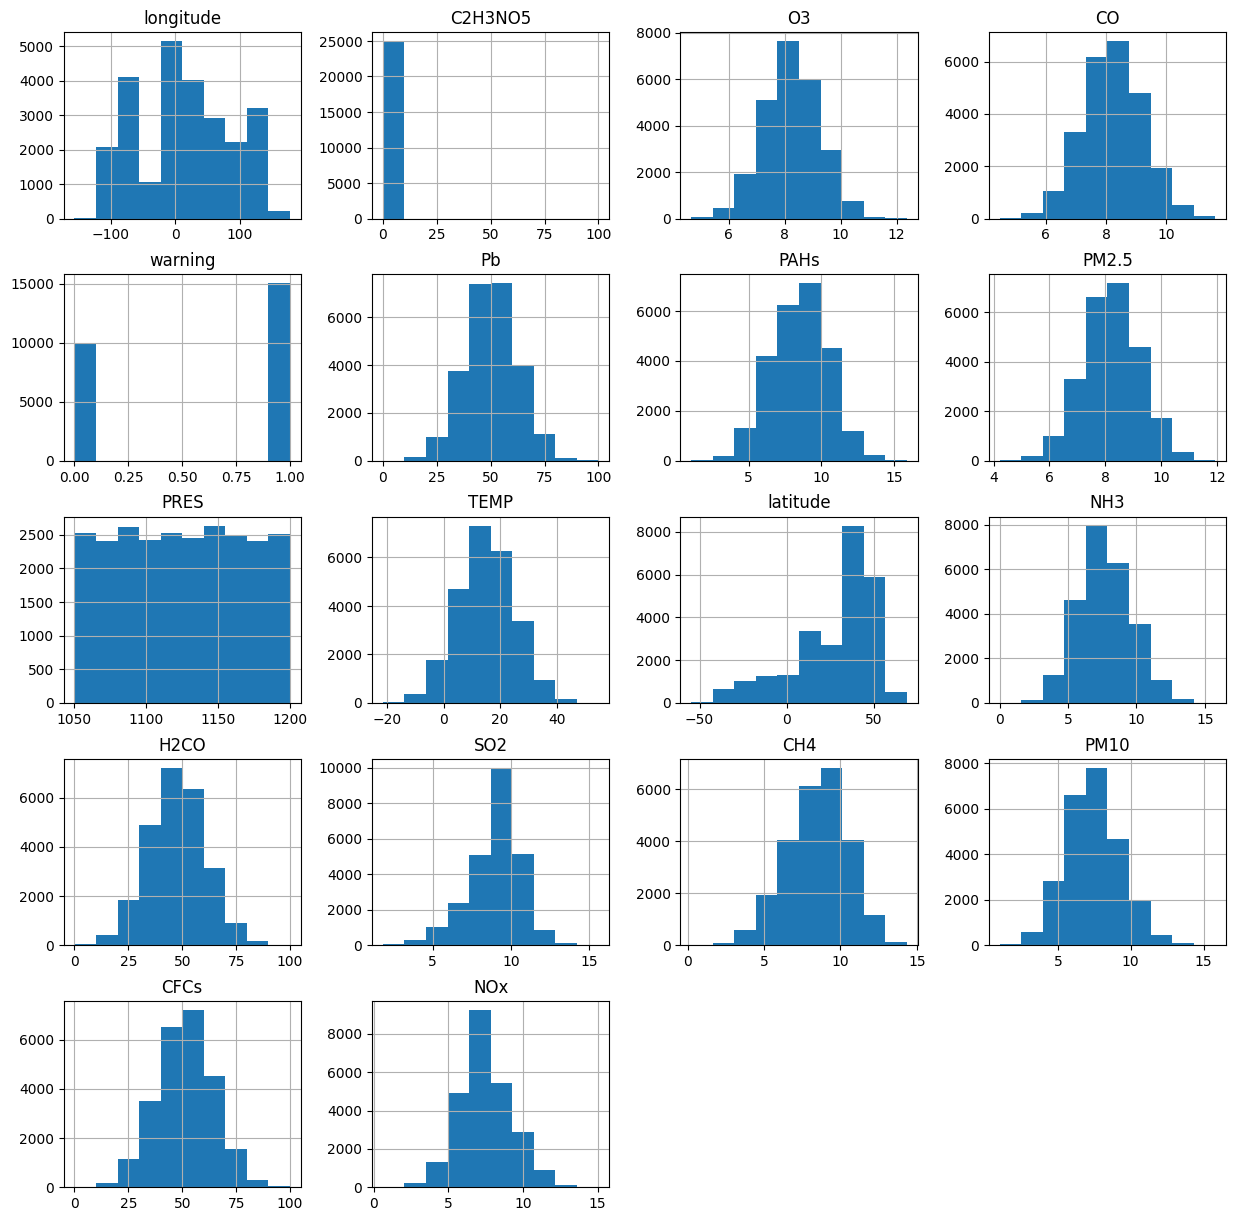

In [159]:
fig = plt.figure(figsize = (15,15))
ax = fig.gca()
merged.hist(ax = ax)

In [160]:
merged = merged[merged.C2H3NO5.between(merged.C2H3NO5.quantile(.05), merged.C2H3NO5.quantile(1))]
merged = merged[merged.O3.between(merged.O3.quantile(.05), merged.O3.quantile(1))]
merged = merged[merged.CO.between(merged.CO.quantile(.05), merged.CO.quantile(1))]
merged = merged[merged.Pb.between(merged.Pb.quantile(.05), merged.Pb.quantile(1))]
merged = merged[merged.PAHs.between(merged.PAHs.quantile(.05), merged.PAHs.quantile(1))]
pm_25 = merged['PM2.5']
merged = merged[merged['PM2.5'].between(merged['PM2.5'].quantile(.05), merged['PM2.5'].quantile(1))]
merged = merged[merged.PRES.between(merged.PRES.quantile(.05), merged.PRES.quantile(1))]
merged = merged[merged.TEMP.between(merged.TEMP.quantile(.05), merged.TEMP.quantile(1))]
merged = merged[merged.NH3.between(merged.NH3.quantile(.05), merged.NH3.quantile(1))]
merged = merged[merged.H2CO.between(merged.H2CO.quantile(.05), merged.H2CO.quantile(1))]
merged = merged[merged.SO2.between(merged.SO2.quantile(.05), merged.SO2.quantile(1))]
merged = merged[merged.CH4.between(merged.CH4.quantile(.05), merged.CH4.quantile(1))]
merged = merged[merged.PM10.between(merged.PM10.quantile(.05), merged.PM10.quantile(1))]
merged = merged[merged.CFCs.between(merged.CFCs.quantile(.05), merged.CFCs.quantile(1))]
merged = merged[merged.NOx.between(merged.NOx.quantile(.05), merged.NOx.quantile(1))]

C:\Users\mraff\AppData\Local\Temp\ipykernel_10432\353805822.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  merged.hist(ax = ax)


array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'C2H3NO5'}>,
        <AxesSubplot:title={'center':'O3'}>,
        <AxesSubplot:title={'center':'CO'}>],
       [<AxesSubplot:title={'center':'warning'}>,
        <AxesSubplot:title={'center':'Pb'}>,
        <AxesSubplot:title={'center':'PAHs'}>,
        <AxesSubplot:title={'center':'PM2.5'}>],
       [<AxesSubplot:title={'center':'PRES'}>,
        <AxesSubplot:title={'center':'TEMP'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'NH3'}>],
       [<AxesSubplot:title={'center':'H2CO'}>,
        <AxesSubplot:title={'center':'SO2'}>,
        <AxesSubplot:title={'center':'CH4'}>,
        <AxesSubplot:title={'center':'PM10'}>],
       [<AxesSubplot:title={'center':'CFCs'}>,
        <AxesSubplot:title={'center':'NOx'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

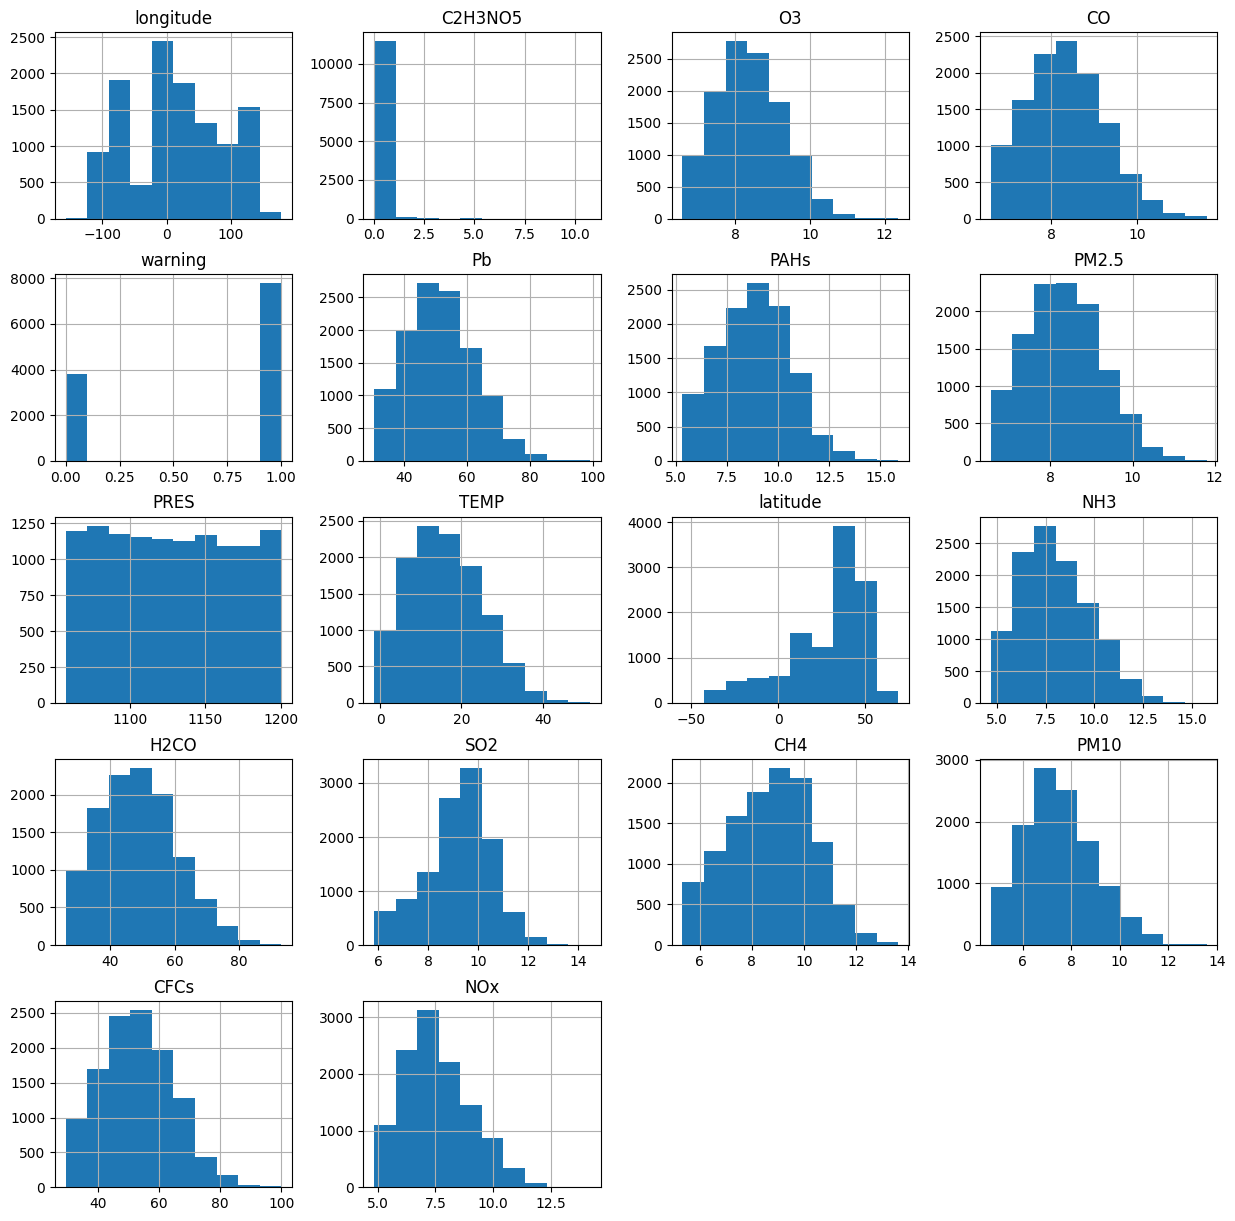

In [161]:
fig = plt.figure(figsize = (15,15))
ax = fig.gca()
merged.hist(ax = ax)

Keďže našou úlohou bolo vyskúšať dve metódy na vysporiadanie sa s outliermi, horný kvantil sme sa rozhodli nahradiť hraničnými hodnotami. 

In [162]:
def replace_outlier(merged, column_name):
    data = merged.copy(deep = True)
    perc_95 = data[column_name].quantile(.95)
    data.loc[data[column_name] > perc_95, column_name] = perc_95 
    return data

In [163]:
columns= ['C2H3NO5','O3','CO', 'Pb', 'PAHs', 'PM2.5','PRES','TEMP','NH3', 'H2CO' ,'SO2', 'CH4','PM10', 'CFCs','NOx']
for column_name in columns:
    merged = replace_outlier(merged, column_name)



C:\Users\mraff\AppData\Local\Temp\ipykernel_10432\353805822.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  merged.hist(ax = ax)


array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'C2H3NO5'}>,
        <AxesSubplot:title={'center':'O3'}>,
        <AxesSubplot:title={'center':'CO'}>],
       [<AxesSubplot:title={'center':'warning'}>,
        <AxesSubplot:title={'center':'Pb'}>,
        <AxesSubplot:title={'center':'PAHs'}>,
        <AxesSubplot:title={'center':'PM2.5'}>],
       [<AxesSubplot:title={'center':'PRES'}>,
        <AxesSubplot:title={'center':'TEMP'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'NH3'}>],
       [<AxesSubplot:title={'center':'H2CO'}>,
        <AxesSubplot:title={'center':'SO2'}>,
        <AxesSubplot:title={'center':'CH4'}>,
        <AxesSubplot:title={'center':'PM10'}>],
       [<AxesSubplot:title={'center':'CFCs'}>,
        <AxesSubplot:title={'center':'NOx'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

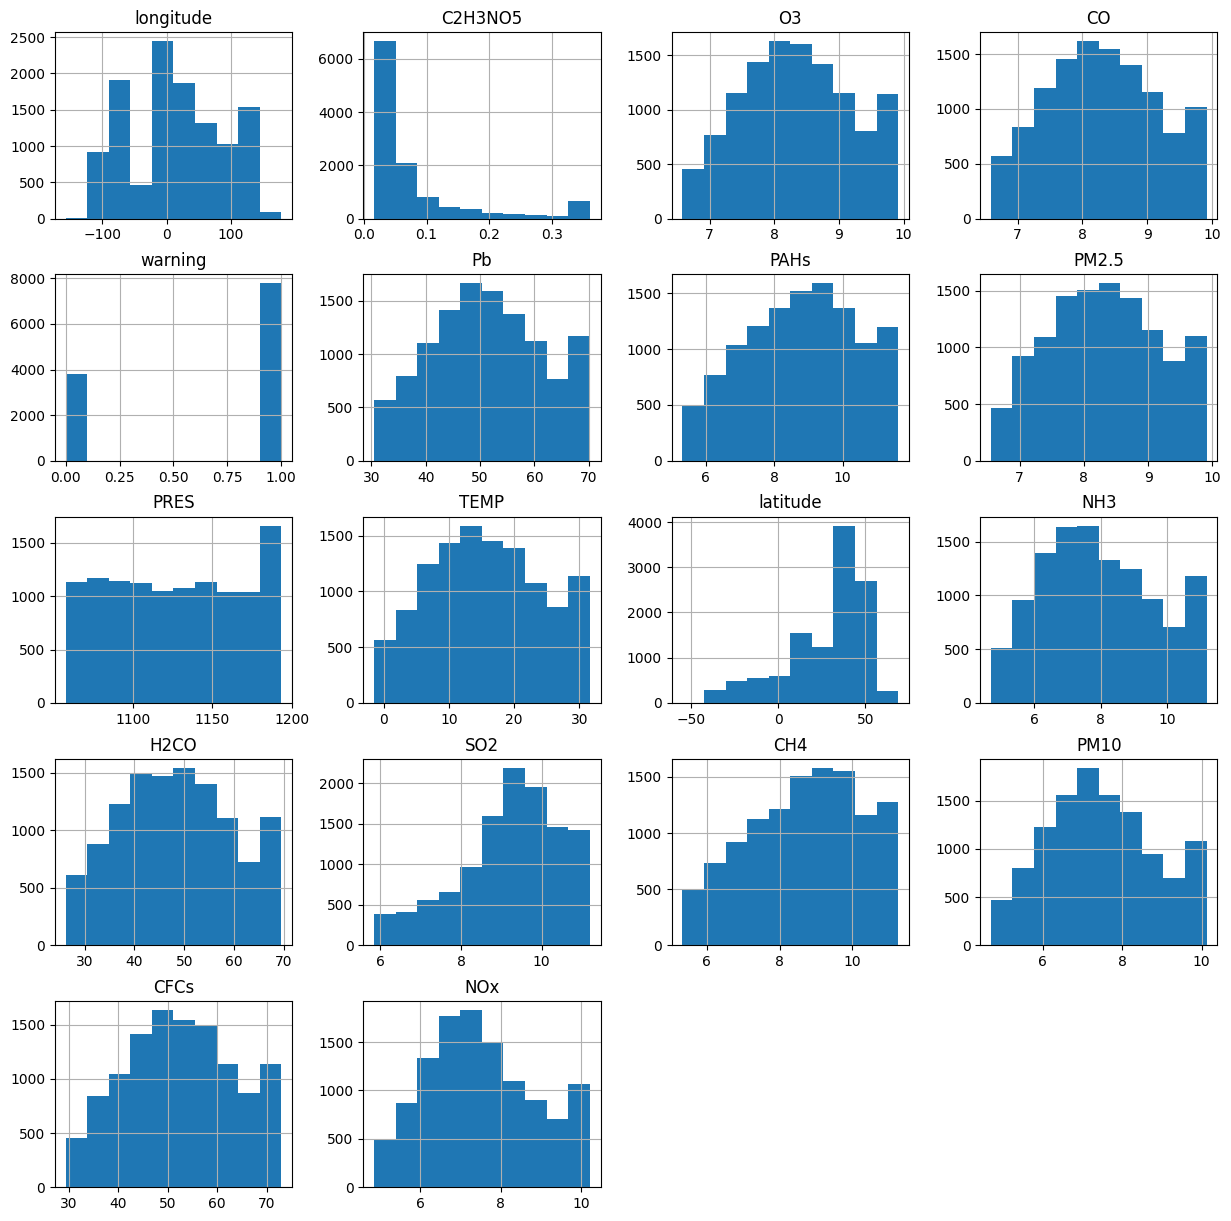

In [164]:
fig = plt.figure(figsize = (15,15))
ax = fig.gca()
merged.hist(ax = ax)